In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
import pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import mlab
import seaborn as sns
%matplotlib inline

mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

In [26]:
def RCRPM_loading(RC,RPM,filename,endtype,densitypath):
    with open(densitypath+filename+endtype+'_readcounts.pickle', 'rb') as f:
        RC[filename]=pickle.load(f)
    with open(densitypath+filename+endtype+'_rpm.pickle', 'rb') as f:
        RPM[filename]=pickle.load(f)
    #return [rcs,rpms]

In [27]:
import multiprocessing
import pickle
import threading
from datetime import datetime

#RC ={} somehow I need to do below to assign this dict to get the value evalutated from the RCRPM_loading
#RPM = {} somehow I need to do below to assign this dict to get the value evalutated from the RCRPM_loading
manager = multiprocessing.Manager()
RC = manager.dict()
RPM = manager.dict()

jobs = []

    
filenames = ['ks'+str(x) for x in range(5,17)]
endtype = '_3map'
densitypath = '/home/kazuki/^profilingdata/20160420_reanalyze/density/'
for filename in filenames:
    job = multiprocessing.Process(target=RCRPM_loading, args=(RC,RPM,filename,endtype,densitypath))
    jobs.append(job)
    job.start()   
    
    
filenames = ['ks'+str(x) for x in range(31,43)]
endtype = '_3map'
densitypath = '/home/kazuki/^profilingdata/20161108_reanalyze/density/'
for filename in filenames:
    job = multiprocessing.Process(target=RCRPM_loading, args=(RC,RPM,filename,endtype,densitypath))
    jobs.append(job)
    job.start()     
    
    
[job.join() for job in jobs] # just to get the time by the below line

print('done')

done


# Collision score

In [28]:
import pickle
with open('/home/kazuki/^data_analysis/^Ecoli_Genome/Ecoli_Gene_TU.pickle','rb') as f:
    Gene_TU_dict = pickle.load(f)

In [29]:
rpkm_dict = {} 
asymmetry_dict = {}
files = ['ks'+str(x) for x in range(5,17)]
for f in files:
    rpm=RPM[f]
    plus_rpm = rpm[0][rpm[0].keys()[0]]
    minus_rpm = rpm[1][rpm[1].keys()[0]]
    
    rpkm_dict[f]={}
    asymmetry_dict[f]={}
    
    for key in Gene_TU_dict.keys():
        if key in asymmetry_dict.keys() or key in rpkm_dict.keys():
            print key +' is overlapping!!!'
            continue
        start = int(Gene_TU_dict[key][2])-1
        end = int(Gene_TU_dict[key][3])
        length = end-start
        if length < 500:
            continue        
        if Gene_TU_dict[key][0] == '+':
            last_start = end-100
            last_end = end+15-15
            allarea = float(sum(plus_rpm[start+15+15:end+15-15]))/float(((end+15-15)-(start+15+15))/1000.0)
            last = float(sum(plus_rpm[last_start:last_end]))/float((last_end-last_start)/1000.0)
            if allarea != 0:
                asymmetry = last/allarea
                asymmetry_dict[f][key]=np.log2(asymmetry)
        if Gene_TU_dict[key][0] == '-':
            last_start = start-15+15
            last_end = start-15+15+100
            allarea = float(sum(minus_rpm[start-15+15:end-15-15]))/float(((end+15-15)-(start+15+15))/1000.0)
            last = float(sum(minus_rpm[last_start:last_end]))/float((last_end-last_start)/1000.0)          
            if allarea != 0:
                asymmetry = last/allarea
                asymmetry_dict[f][key]=np.log2(asymmetry)
                
                rpkm_dict[f][key] = allarea

In [30]:
df_base_CDS = pd.read_csv('rrf_CDS.csv')
df_base_CDS = df_base_CDS.loc[:,~df_base_CDS.columns.str.contains('^Unnamed')]

In [31]:
data_masta = []

library_list = ['ks'+str(x) for x in range(14,17)] # high salt
mRNA_library_list = ['ks'+str(x) for x in range(20,23)]

for library,mRNA_library in zip(library_list,mRNA_library_list):
    ##########################################################################################
    good_1 = df_base_CDS[library+'_rpc']>0.05
    good_2 = df_base_CDS[mRNA_library+'_rpc']>0.05

    low_TE = df_base_CDS['TE_'+library+'/'+mRNA_library]<df_base_CDS['TE_'+library+'/'+mRNA_library].quantile(0.40)
    low_TE_genes = []
    for gene in df_base_CDS[low_TE&good_1&good_2]['gene'].values:
        low_TE_genes.append(gene)
        
    high_TE = df_base_CDS['TE_'+library+'/'+mRNA_library]>df_base_CDS['TE_'+library+'/'+mRNA_library].quantile(0.80)
    high_TE_genes = []
    for gene in df_base_CDS[high_TE&good_1&good_2]['gene'].values:
        high_TE_genes.append(gene)
    ##########################################################################################

    data = []
    for gene  in asymmetry_dict[library].keys():
        if gene in low_TE_genes:
            data.append(asymmetry_dict[library][gene])
    data_masta.append(data)

    data = []
    for gene  in asymmetry_dict[library].keys():
        if gene in high_TE_genes:
            data.append(asymmetry_dict[library][gene])   
    data_masta.append(data)

import scipy
x=0
while x <6:
    print scipy.stats.mannwhitneyu(data_masta[x], data_masta[x+1], use_continuity=True, alternative=None)
    x+=2

MannwhitneyuResult(statistic=32219.0, pvalue=7.602240752647995e-23)
MannwhitneyuResult(statistic=31384.0, pvalue=6.592143497946345e-16)
MannwhitneyuResult(statistic=53348.0, pvalue=5.368395251616874e-15)


([<matplotlib.axis.YTick at 0x7f5d6ba70310>,
 <a list of 5 Text yticklabel objects>)

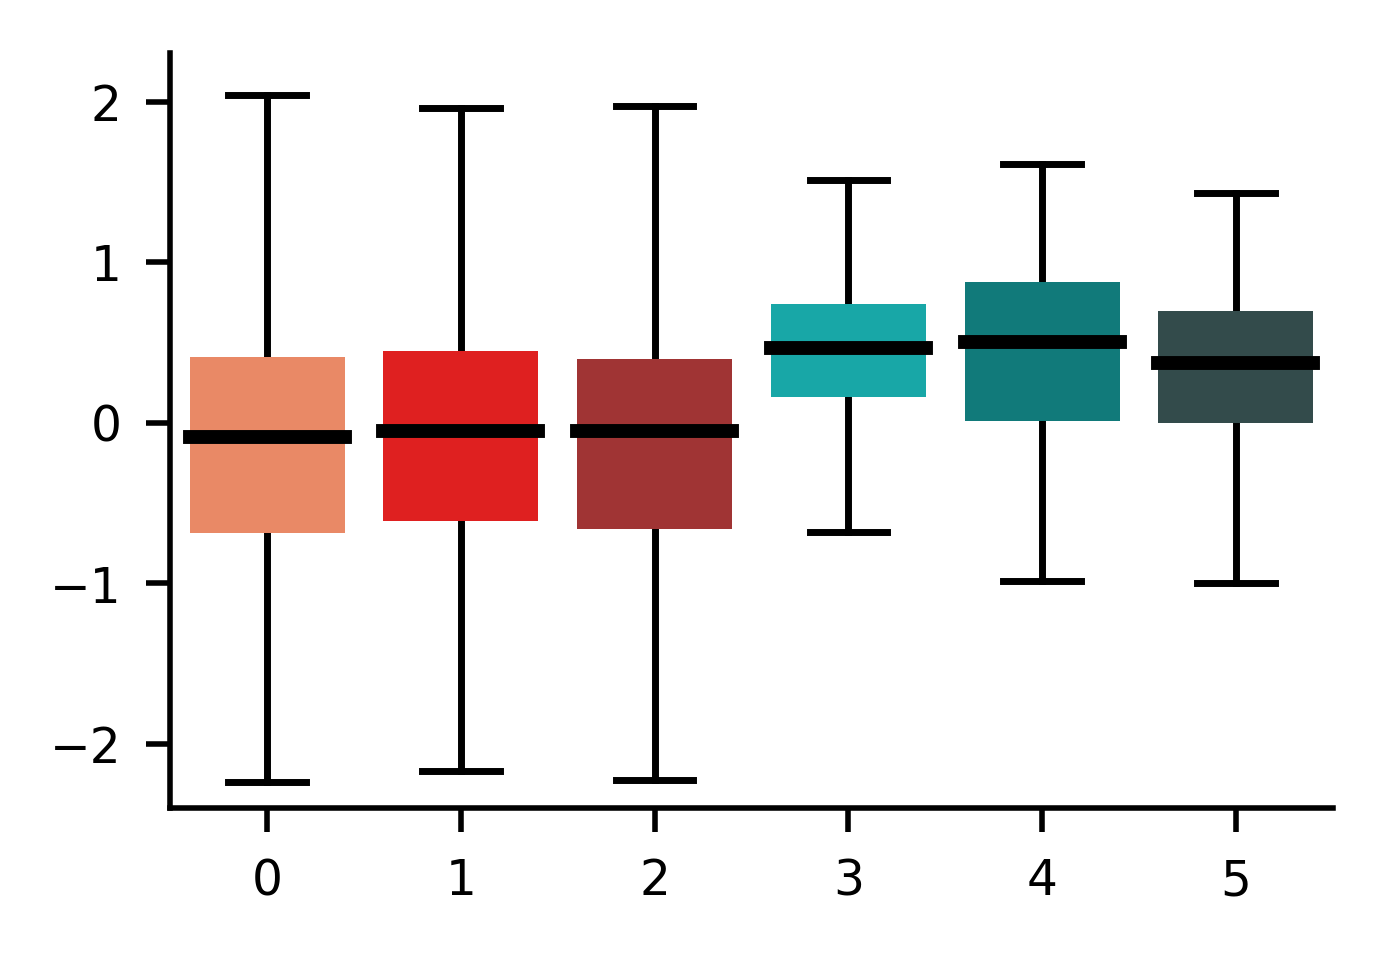

In [32]:
data_reorder = []
x = 0
while x < 6:
    data_reorder.append(data_masta[x])
    x+=2
x = 1
while x < 7:
    data_reorder.append(data_masta[x])
    x+=2

fig, ax = plt.subplots()
fig.set_dpi(500)
fig.set_size_inches(3, 2)

ax = sns.boxplot(data=data_reorder,
                 showfliers=False,
                 linewidth=1,
                palette=[
                  'coral','red','firebrick','c','darkcyan','darkslategray'],
                capprops={'color': 'black', 'linewidth': 1,"zorder":10},
                 medianprops = {'color': 'black', 'linewidth': 2,"zorder":20}, 
                 boxprops = {'edgecolor': 'black', 'linewidth': 0, "zorder":10},
                 whiskerprops={'color': 'black','linewidth':1, "zorder":10})

#ax.axhline(y=0,linewidth=1, color='dimgrey',linestyle='--')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()
plt.tick_params(labelsize=7)
plt.ylim(-2.4,2.3)
plt.yticks([-2,-1,0,1,2])
#plt.savefig('figs_highlow/fig_collided.pdf', dpi=500)

# 3UTR score

In [33]:
files = ['ks' + str(x) for x in range(5,23)]
for f in files:
    df_base_CDS[f+'_utr/orf']=df_base_CDS[f+'_3utr_rpkm']/df_base_CDS[f+'_rpkm']

In [34]:
data_masta__2 = []

library_list = ['ks'+str(x) for x in range(14,17)] # high salt
mRNA_library_list = ['ks'+str(x) for x in range(20,23)]

for library,mRNA_library in zip(library_list,mRNA_library_list):
    ##########################################################################################
    good_1 = df_base_CDS[library+'_rpc']>0.1
    good_2 = df_base_CDS[mRNA_library+'_rpc']>0.1

    low_TE = df_base_CDS['TE_'+library+'/'+mRNA_library]<df_base_CDS['TE_'+library+'/'+mRNA_library].quantile(0.40)
    data_masta__2.append(df_base_CDS[low_TE&good_1&good_2][library+'_utr/orf'].apply(np.log2).replace([np.inf,-np.inf],np.nan))
        
    high_TE = df_base_CDS['TE_'+library+'/'+mRNA_library]>df_base_CDS['TE_'+library+'/'+mRNA_library].quantile(0.80)
    data_masta__2.append(df_base_CDS[high_TE&good_1&good_2][library+'_utr/orf'].apply(np.log2).replace([np.inf,-np.inf],np.nan))
    
import scipy
x=0
while x <6:
    print scipy.stats.mannwhitneyu(data_masta__2[x], data_masta__2[x+1], use_continuity=True, alternative=None)
    x+=2

MannwhitneyuResult(statistic=27558.0, pvalue=7.311456685816035e-84)
MannwhitneyuResult(statistic=26561.0, pvalue=9.963362090769901e-75)
MannwhitneyuResult(statistic=60448.0, pvalue=3.8644193351791435e-58)


([<matplotlib.axis.YTick at 0x7f5d6bfe5d10>,
 <a list of 3 Text yticklabel objects>)

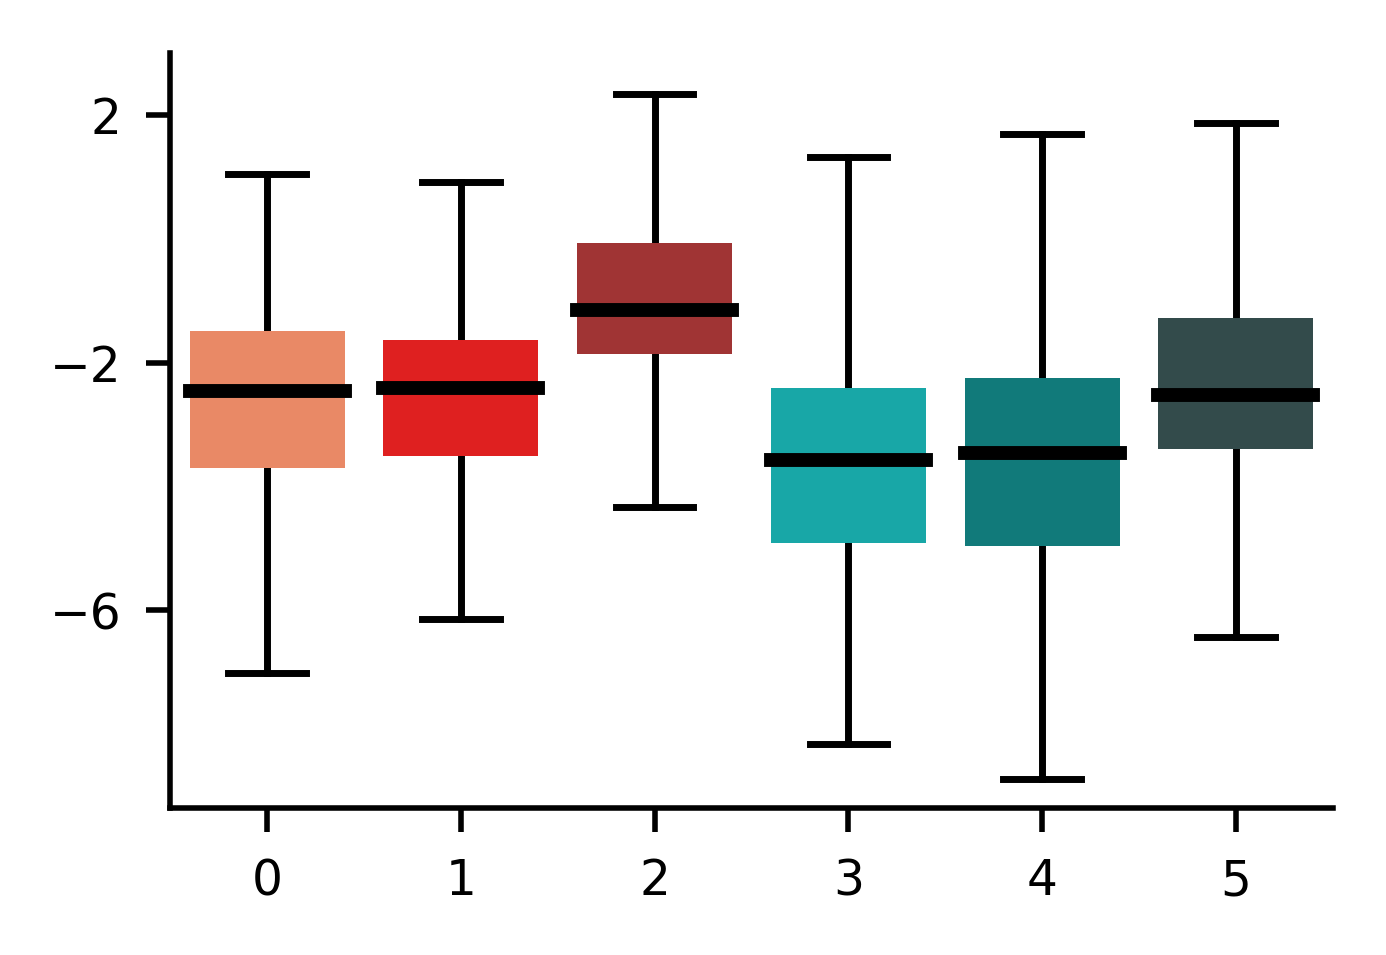

In [35]:
data_reorder__2 = []
x = 0
while x < 6:
    data_reorder__2.append(data_masta__2[x])
    x+=2
x = 1
while x < 7:
    data_reorder__2.append(data_masta__2[x])
    x+=2

fig, ax = plt.subplots()
fig.set_dpi(500)
fig.set_size_inches(3, 2)

ax = sns.boxplot(data=data_reorder__2,
                 showfliers=False,
                 linewidth=1,
                palette=[
                  'coral','red','firebrick','c','darkcyan','darkslategray'],
                capprops={'color': 'black', 'linewidth': 1,"zorder":10},
                 medianprops = {'color': 'black', 'linewidth': 2,"zorder":20}, 
                 boxprops = {'edgecolor': 'black', 'linewidth': 0, "zorder":10},
                 whiskerprops={'color': 'black','linewidth':1, "zorder":10})

#ax.axhline(y=0,linewidth=1, color='dimgrey',linestyle='--')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine()
plt.tick_params(labelsize=7)
plt.ylim(-9.2,3)
plt.yticks([-6,-2,2])
#plt.savefig('figs_highlow/fig_utrorf.pdf', dpi=500)